## Notebook to examine error (standard deviation) of RI using bootstrap method
This is estimated for RI for 1998-2010 literature

In [5]:
import pandas as pd
import h5py
import os

In [6]:
# Config section
version = '19_2_125_rec1'

#timeseries_filename = f"../data/time_series_characteristics_{version}.csv"

viz_data_filename = f"../data/viz_data_{version}.hdf5"
Start_Year = 1998
End_Year = 2010

# viz 19 (125 topics)
topics_to_estimate_errors = [29, 32, 45, 64, 70, 74, 91, 95, 97, 120]

In [7]:
# some code to load h5py file we need to use
def load_topic_bibcode_h5py(viz_data_loc: os.PathLike)->pd.DataFrame:
    #Load object parameters from an hdf database.
    #Args:
    #    viz_data_loc: path to opinionated hdf file
    
    with h5py.File(viz_data_loc, "r") as f0:
        embedding = f0["embedding"][:]
        topic_coherences = f0["topic_coherences"][:]
        paper_ids = f0["paper_ids"][:]
        bibcodes = f0["bibcodes"][:]

    df = pd.DataFrame(embedding)
    df.index = paper_ids
    df['year'] = [ int(bibcode[0:4]) for bibcode in bibcodes]
        
    return df

In [10]:
years = range(Start_Year, End_Year+1)
    
data = load_topic_bibcode_h5py(viz_data_filename)
data.reset_index(drop=True, inplace=True)
data = data[data['year']>=Start_Year]
data = data[data['year']<=End_Year]
data = data.sort_values('year')
#data

In [11]:
data_by_year = { year-Start_Year:data[data['year']==year].reset_index(drop=True) for year in [Start_Year, End_Year] }

In [12]:
data_by_year.keys()

dict_keys([0, 12])

In [13]:
data_by_year[12]

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,year
0,0.000780,0.000822,0.000846,0.000817,0.000760,0.000805,0.000798,0.000800,0.000851,0.000857,...,0.000781,0.000797,0.000829,0.000787,0.000800,0.000827,0.000816,0.000811,0.000803,2010
1,0.000867,0.000914,0.000940,0.000907,0.000844,0.000895,0.000886,0.000889,0.000945,0.000952,...,0.000868,0.000886,0.000921,0.000875,0.000889,0.000918,0.000907,0.000902,0.000893,2010
2,0.000975,0.001028,0.001058,0.001021,0.000949,0.001006,0.000997,0.001000,0.123006,0.001071,...,0.000977,0.000996,0.001036,0.000984,0.001000,0.001033,0.001020,0.001014,0.001004,2010
3,0.001949,0.002054,0.002114,0.002039,0.001897,0.002011,0.001992,0.001998,0.002125,0.002139,...,0.001952,0.001991,0.002070,0.001966,0.001999,0.002064,0.002038,0.002027,0.002007,2010
4,0.001560,0.001644,0.001692,0.001632,0.001518,0.001609,0.001594,0.001599,0.001700,0.001712,...,0.001562,0.001593,0.001656,0.001574,0.001599,0.001652,0.001631,0.205245,0.001606,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.000867,0.000914,0.000940,0.000907,0.000844,0.000895,0.000886,0.000889,0.000945,0.000952,...,0.000868,0.000886,0.000921,0.000875,0.000889,0.000918,0.000907,0.000902,0.000893,2010
7110,0.002597,0.002737,0.002817,0.002718,0.002528,0.002680,0.002655,0.002662,0.002831,0.002851,...,0.002601,0.002653,0.002758,0.002621,0.002663,0.002751,0.002716,0.002701,0.002674,2010
7111,0.002597,0.002737,0.002817,0.002718,0.002528,0.002680,0.002655,0.002662,0.002831,0.002851,...,0.002601,0.002653,0.002758,0.002621,0.002663,0.002751,0.002716,0.002701,0.002674,2010
7112,0.001114,0.001174,0.001209,0.001166,0.001085,0.001150,0.001139,0.001142,0.001215,0.363014,...,0.001116,0.001138,0.001184,0.001124,0.001143,0.001180,0.001166,0.001159,0.001147,2010


In [14]:

import numpy as np
import statistics

# cagr calculation
def cagr (low:float, high:float, time:int)->float:
    return (high/low)**(1/time) - 1.

def ri (cagr:float, tcs:float, offset:float=0.1)->float:
    return (cagr + offset) * tcs;


# sample timeseries data for bootstrap
import random
def sample_timeseries(topic, data_by_year:dict, samples_per_year:int=100, threshold:float=0.0):
    
    ''' random sample, no replacement '''
    num_topics = len(data_by_year[0].columns)-1
    #timeseries = { topic:{ yr:0. for yr in data_by_year.keys()} for topic in range(0,num_topics) }
    timeseries = [0. for i in range(0, len(data_by_year.keys()))]
    
    # using random sampling of the rows
    # calculate timeseries for each topic
    # just Pick off first and last years
    for year in [0, 1]: #data_by_year.keys():
        
        #print (year)
        data = data_by_year[year * (End_Year-Start_Year)]
        #print (data)
        row_seq = list(range(0, len(data)))
        #print (row_seq)
        
        try:
            random_rows = random.sample(row_seq, samples_per_year)
        except Exception as ex:
            print (f"Fail on topic {topic}")
            raise ex
            
        for random_row in random_rows:
            row_data = data[data.index==random_row]
            value = list(row_data[topic].values)[0]
            
            # dont co-add if below this threshold
            if value >= threshold:
                timeseries[year] += value

    return timeseries

# sample timeseries data for bootstrap
def sample_timeseries_repl(topic, data_by_year:dict, samples_per_year:int=100, threshold:float=0.0):
    
    ''' random sample with replacement. '''
    num_topics = len(data_by_year[0].columns)-1
    #timeseries = { topic:{ yr:0. for yr in data_by_year.keys()} for topic in range(0,num_topics) }
    timeseries = [0. for i in range(0, len(data_by_year.keys()))]
    
    # using random sampling of the rows
    # calculate timeseries for each topic
    # just pick off start and end years
    for year in [0, 1]:# data_by_year.keys():
        
        #print (year)
        data = data_by_year[year * (End_Year-Start_Year)]
        #print (data)
        row_seq = list(range(0, len(data)))
        #print (row_seq)
        
        for i in range(0, samples_per_year):
            
            random_row = random.choice(row_seq)
            row_data = data[data.index==random_row]
            value = list(row_data[topic].values)[0]
            
            # dont co-add if below this threshold
            if value >= threshold:
                timeseries[year] += value

    return timeseries

def bootstrap_estimate (topic:int, data_by_year:dict, \
                       num_times_to_sample:int=10, num_data_samples:int=10000,\
                       replacement:bool=True):
    
    """ Returns the standard deviation for selected topic timeseries CAGR values """
    
    stats = []
    for i in range(0, num_times_to_sample):
        if replacement:
            timeseries = pd.Series(sample_timeseries_repl(topic, data_by_year, num_data_samples))
        else:
            timeseries = pd.Series(sample_timeseries(topic, data_by_year, num_data_samples))
            
        #print (timeseries)
        #t_size = len(timeseries)-1
        t_start = timeseries[0]      
        t_end = timeseries[1]

        #print (f"s:%s e:%s size:%s" % (t_start, t_end, t_size))
        if t_start != 0:
            cgr = cagr(t_start, t_end, 13)
            tcs = timeseries.sum()
            
            #print(f"   cagr:{v}")
            stats.append(ri(cgr, tcs))
    
    #calculate mean, standard deviation
    return statistics.mean(stats), np.std(stats)
    


In [15]:
# choose to sample ~70% of the smallest year size
len(data_by_year[0]) * 0.7

3524.5

In [16]:
import time
start_time = time.time()

# bootstrap w/replacement is same as w/o replacement according to:
#  https://stats.stackexchange.com/questions/69744/why-at-all-consider-sampling-without-replacement-in-a-practical-application
# when applied to first-order statistics like mean and variance. w/o replacement should
# be used for higher order statistics (e.g. skewness, kurtosis)

# takes about 64 sec per ~18000 data samples per topic 
#result = bootstrap_estimate(64, data_by_year, 10, 18000)
#print (f" time to run: %5.2f sec" % (time.time()-start_time))
#result

In [17]:
# Do the bootstrap estimate
results = {}
for topic in topics_to_estimate_errors:
    print (f"Doing topic: {topic}")
    results[topic] = bootstrap_estimate(topic, data_by_year, 10, 18000, replacement=True)
    #result = bootstrap_estimate(64, data_by_year, 10, 18000)

Doing topic: 29
Doing topic: 32
Doing topic: 45
Doing topic: 64
Doing topic: 70
Doing topic: 74
Doing topic: 91
Doing topic: 95
Doing topic: 97
Doing topic: 120


In [18]:
results

{29: (15.367255348670595, 1.2883074474498757),
 32: (36.8858005569407, 1.6746136017891649),
 45: (22.18232649766996, 0.8646972348725759),
 64: (34.60144220394569, 1.4824752144154327),
 70: (19.676714463468993, 1.0886017033612856),
 74: (31.356531377709356, 0.8528814482944842),
 91: (19.14815262952329, 1.3313716427937898),
 95: (23.98492233940427, 0.9065853597580703),
 97: (19.673199707404365, 1.3607915208585109),
 120: (29.87788144761728, 1.682540812796518)}

In [19]:
#timeseries_filename='../time_series_characteristics_11_weight_thr0.05.csv'
# read in data with various info, each row is a topic number 
#timeseries_data = pd.read_csv(timeseries_filename, index_col=False)
#timeseries_data['count'][64]

In [24]:
topics = [t for t in results.keys()]
mean   = [results[t][0] for t in topics]
std    = [results[t][1] for t in topics]
r_data = pd.DataFrame({'topic':topics, 'mean':mean, 'std':std })

# save 
r_data.to_csv(f'../results/bootstrap_error_est_results_ri_repl_1998-2010_{version}.csv')
r_data

,topic,mean,std
0,29,15.367255,1.288307
1,32,36.885801,1.674614
2,45,22.182326,0.864697
3,64,34.601442,1.482475
4,70,19.676714,1.088602
5,74,31.356531,0.852881
6,91,19.148153,1.331372
7,95,23.984922,0.906585
8,97,19.673200,1.360792
9,120,29.877881,1.682541


In [25]:
r_data['std'].mean()

1.2532865986389707

<AxesSubplot: title={'center': 'Bootstrap Error Estimation\nRI'}, xlabel='mean', ylabel='std'>

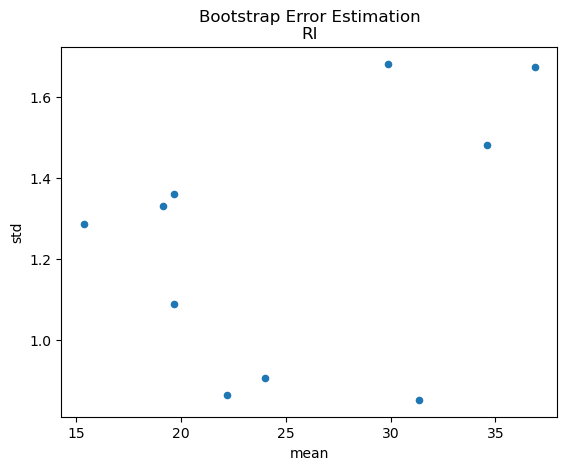

In [22]:
r_data.plot(kind='scatter', x='mean', y='std', title="Bootstrap Error Estimation\nRI")